# XGBoost Article

The data here is taken form the Data Hackathon3.x - 1. 1. http://datahack.analyticsvidhya.com/contest/data-hackathon-3x
https://github.com/aarshayj/Analytics_Vidhya/tree/master/Articles/Parameter_Tuning_XGBoost_with_Example
https://weiwenku.net/d/100702111

## Import Libraries:

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import os
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/Users/liouscott/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/liouscott/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
os.chdir("/Users/liouscott/Documents/scott/machine learning/Analytics_Vidhya-master/Articles/Parameter_Tuning_XGBoost_with_Example/")

## Load Data:

The data has gone through following pre-processing:
1. City variable dropped because of too many categories
2. DOB converted to Age | DOB dropped
3. EMI_Loan_Submitted_Missing created which is 1 if EMI_Loan_Submitted was missing else 0 | EMI_Loan_Submitted dropped
4. EmployerName dropped because of too many categories
5. Existing_EMI imputed with 0 (median) - 111 values were missing
6. Interest_Rate_Missing created which is 1 if Interest_Rate was missing else 0 | Interest_Rate dropped 
7. Lead_Creation_Date dropped because made little intuitive impact on outcome
8. Loan_Amount_Applied, Loan_Tenure_Applied imputed with missing
9. Loan_Amount_Submitted_Missing created which is 1 if Loan_Amount_Submitted was missing else 0 | Loan_Amount_Submitted dropped 
10. Loan_Tenure_Submitted_Missing created which is 1 if Loan_Tenure_Submitted was missing else 0 | Loan_Tenure_Submitted dropped 
11. LoggedIn, Salary_Account removed
12. Processing_Fee_Missing created which is 1 if Processing_Fee was missing else 0 | Processing_Fee dropped
13. Source - top 2 kept as is and all others combined into different category
14. Numerical and One-Hot-Coding performed

In [3]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [4]:
train.shape, test.shape

((87020, 51), (37717, 50))

In [8]:
target='Disbursed'
IDcol = 'ID'

In [9]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

## Define a function for modeling and cross-validation

This function will do the following:
1. fit the model
2. determine training accuracy
3. determine training AUC
4. determine testing AUC
5. update n_estimators with cv function of xgboost package
6. plot Feature Importance 

In [5]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print (cvresult)
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Step 1- Find the number of estimators for a high learning rate

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.765980      0.013074        0.770105       0.012648
1         0.791815      0.019805        0.797879       0.006949
2         0.803918      0.019349        0.809595       0.004482
3         0.802861      0.021466        0.811680       0.005589
4         0.808680      0.017278        0.818140       0.007905
5         0.811605      0.016981        0.820571       0.008872
6         0.815010      0.016898        0.826477       0.005617
7         0.818460      0.017575        0.829731       0.004986
8         0.819429      0.017417        0.832536       0.004061
9         0.821038      0.018386        0.835061       0.004060
10        0.821466      0.017760        0.836950       0.004341
11        0.821979      0.017233        0.838639       0.004035
12        0.822466      0.017317        0.840275       0.003570
13        0.822469      0.016424        0.841169       0.003396
14        0.822711      0.015809        

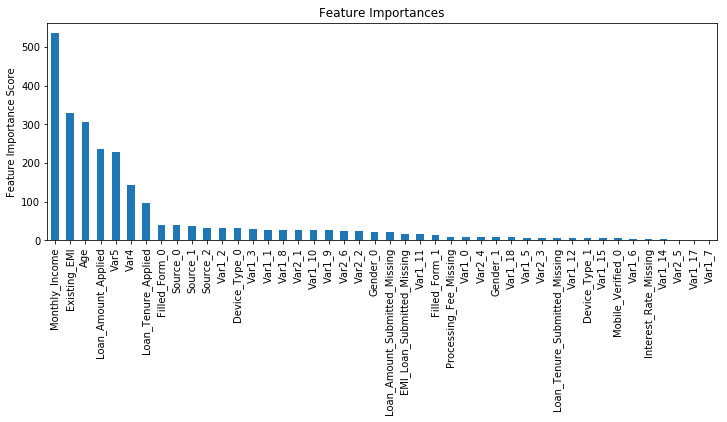

In [10]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)

## Step 2: Tune max_depth and min_child_weight

In [37]:
param_test1 = {
 'max_depth':list(range(3,10,2)),
 'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=list(range(3,10,2)),min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83690, std: 0.00821, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83730, std: 0.00858, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83713, std: 0.00847, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84051, std: 0.00748, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84112, std: 0.00595, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84123, std: 0.00619, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83772, std: 0.00518, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83672, std: 0.00579, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83658, std: 0.00355, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.82690, std: 0.00622, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.82909, std: 0.00560, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83203, std: 0.00708, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

In [38]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.84031, std: 0.00658, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.84061, std: 0.00700, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.84125, std: 0.00723, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.83988, std: 0.00612, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.84123, std: 0.00619, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83995, std: 0.00591, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.83905, std: 0.00635, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.83904, std: 0.00656, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.83844, std: 0.00682, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 4, 'min_child_weight': 6},
 0.8412491517082822)

In [12]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=2, missing=None, n_estimators=140, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.875742


([mean: 0.84125, std: 0.00723, params: {'min_child_weight': 6},
  mean: 0.84028, std: 0.00710, params: {'min_child_weight': 8},
  mean: 0.83920, std: 0.00674, params: {'min_child_weight': 10},
  mean: 0.83996, std: 0.00729, params: {'min_child_weight': 12}],
 {'min_child_weight': 6},
 0.8412491517082822)

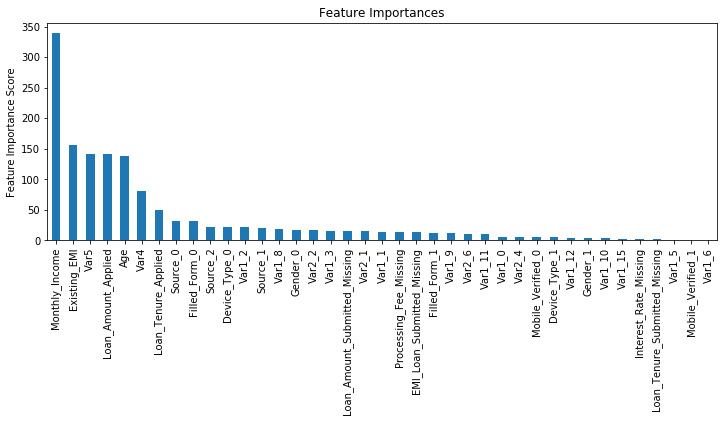

In [15]:
modelfit(gsearch2b.best_estimator_, train, predictors)
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

## Step 3: Tune gamma

In [16]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84125, std: 0.00723, params: {'gamma': 0.0},
  mean: 0.83996, std: 0.00695, params: {'gamma': 0.1},
  mean: 0.84045, std: 0.00639, params: {'gamma': 0.2},
  mean: 0.84032, std: 0.00673, params: {'gamma': 0.3},
  mean: 0.84061, std: 0.00692, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8412491517082822)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.885938


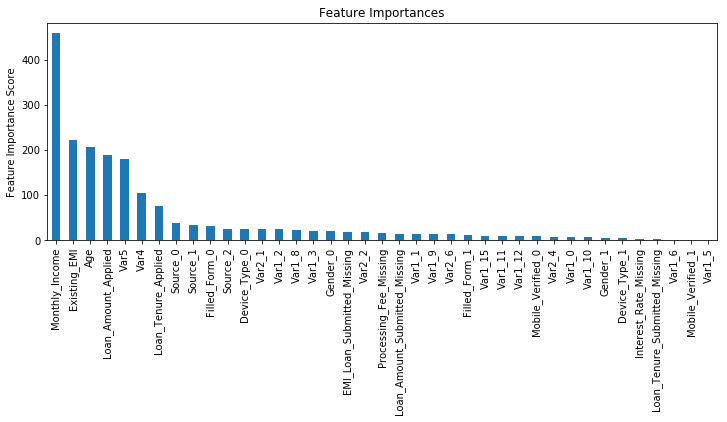

In [17]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors)

## Step 4: Tune subsample and colsample_bytree

In [11]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83723, std: 0.00889, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.83834, std: 0.00772, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.83946, std: 0.00813, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.83845, std: 0.00831, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.83816, std: 0.00651, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.83797, std: 0.00668, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.83956, std: 0.00824, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.83892, std: 0.00626, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.83914, std: 0.00794, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.83974, std: 0.00687, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.84102, std: 0.00715, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.84029, std: 0.00645, params: {'colsample_bytree': 0.8, 'subsample'

In [12]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=177, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.75, 0.8, 0.85], 'colsample_bytree': [0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

## Step 5: Tuning Regularization Parameters

In [13]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.83999, std: 0.00643, params: {'reg_alpha': 1e-05},
  mean: 0.84084, std: 0.00639, params: {'reg_alpha': 0.01},
  mean: 0.83985, std: 0.00831, params: {'reg_alpha': 0.1},
  mean: 0.83989, std: 0.00707, params: {'reg_alpha': 1},
  mean: 0.81343, std: 0.01541, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 0.8408427425716655)

In [14]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.83999, std: 0.00643, params: {'reg_alpha': 0},
  mean: 0.83978, std: 0.00663, params: {'reg_alpha': 0.001},
  mean: 0.84118, std: 0.00651, params: {'reg_alpha': 0.005},
  mean: 0.84084, std: 0.00639, params: {'reg_alpha': 0.01},
  mean: 0.84008, std: 0.00690, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.005},
 0.8411834794358158)

     test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0         0.765725      0.013018        0.769406       0.012578
1         0.791744      0.019637        0.796396       0.005787
2         0.801294      0.021203        0.806964       0.003582
3         0.801912      0.022879        0.809265       0.005097
4         0.806891      0.018402        0.814882       0.006905
5         0.812066      0.019338        0.819227       0.002772
6         0.813862      0.020162        0.822875       0.003401
7         0.816408      0.019659        0.824728       0.003624
8         0.817719      0.018140        0.827068       0.003195
9         0.818366      0.018035        0.828402       0.003668
10        0.818774      0.017109        0.829024       0.003729
11        0.819359      0.016586        0.830094       0.003779
12        0.819800      0.016049        0.831077       0.003659
13        0.819865      0.015674        0.831560       0.003225
14        0.820316      0.014881        

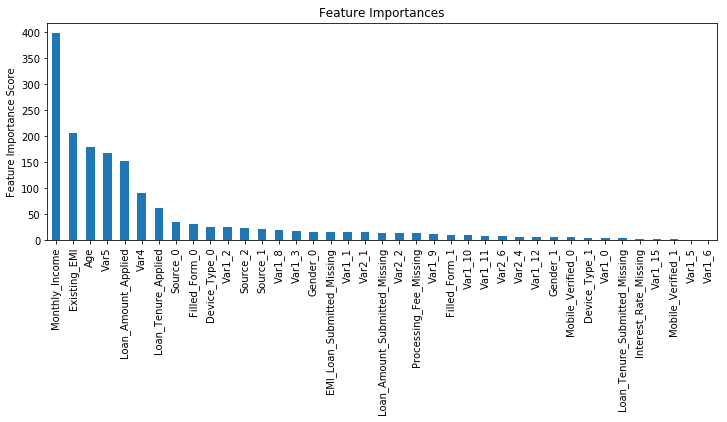

In [15]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

## Step 6: Reducing Learning Rate

      test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0          0.765725      0.013018        0.769406       0.012578
1          0.790812      0.019840        0.795020       0.004788
2          0.795646      0.019741        0.799100       0.007066
3          0.796592      0.020244        0.800572       0.007793
4          0.800013      0.019729        0.805694       0.010354
5          0.801297      0.020436        0.805717       0.010672
6          0.801266      0.019937        0.806271       0.010660
7          0.801944      0.020498        0.807215       0.011024
8          0.803078      0.020740        0.809522       0.008318
9          0.806947      0.020669        0.812822       0.004015
10         0.807237      0.020716        0.813493       0.003683
11         0.807306      0.020808        0.814094       0.004012
12         0.809352      0.018002        0.816144       0.004347
13         0.810312      0.016833        0.817655       0.003847
14         0.810377      

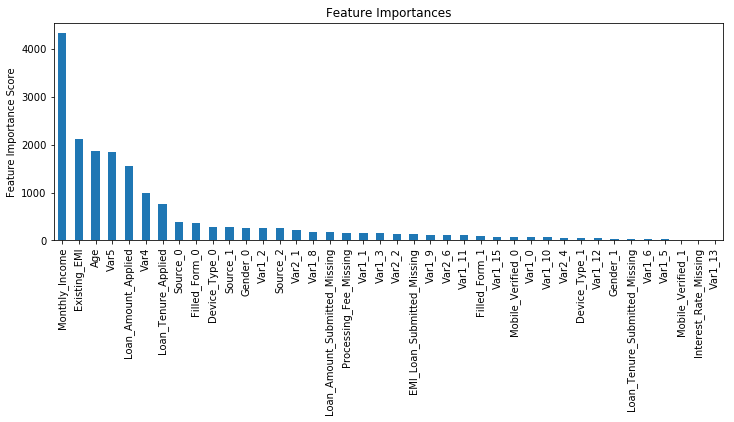

In [16]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, predictors)